In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import calinski_harabaz_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import sys
from gmvae_model import GMVAE
from utils import *

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
k = 2
n_x = 10
n_z = 2

# Load toy dataset

In [3]:
true_clusters = 3
dataset = load_and_mix_data('generated_from_cluster',true_clusters,True)
print(dataset.train.data.shape)

(1350, 10)


In [4]:
print(dataset.test.labels.shape)

(150, 3)


# Create model

In [5]:
model = GMVAE(k=k, n_x=n_x, n_z=n_z)

graph written


In [6]:
def sample_z(sess, X, model, multiplier, k, n_z):
    '''
        For each datapoint in X, sample its latent representation 'multiplier' times
        Returns: z - all latent vectors, ordered in [z1,z2,...,ZM,another z1,another z2,...], 
                    which makes it easy to divide into 'multiplier' "batches"
                 category - for each latent vector, an indicator showing which cluster it belongs to
    '''
    M = len(X)
    all_z = np.zeros((M*multiplier, k, n_z))
    for i in range(k):
        for j in range(multiplier):
            all_z[M*j:M*(j+1), i] = sess.run(model.z[i],
                                    feed_dict={'x:0': X})

    qy = sess.run(model.qy, feed_dict={'x:0': X})
    category = qy.argmax(axis=1)
    category = np.concatenate([category for j in range(multiplier)])
    y_pred = one_hot(category, depth=k).astype(bool)

    z = all_z[y_pred]
    return z, category

In [7]:
def pca(X, n_z):
    '''
        Performs dimensionality reduction of dataset X, down to n_z dimensions
        Returns: x - a reduced dimensionality representation of X
    '''
    pca_solver = PCA(n_components = n_z)
    x = pca_solver.fit_transform(X)
    return x

In [8]:
def gm(X, k):
    '''
        Clusters all data points in X into k clusters 
        Returns: labels - for each data point, an indicator showing which cluster it belongs to
    '''
    gm_solver = GaussianMixture(n_components = k)
    gm_solver.fit(X)
    labels = gm_solver.predict(X)
    return labels

In [9]:
def perform_pca_and_cluster(X, k, n_z):
    '''
        Performs PCA dimensionality reduction on X and clusters the result into k clusters
        Returns: X_reducted - a reduced dimensionality representation of X
                 X_labels - for each data point in X_reducted, an indicator showing which cluster it belongs to
    '''
    X_reducted = pca(X, n_z)
    X_labels = gm(X_reducted, k)
    return X_reducted, X_labels

In [10]:
def compute_pairwise_stability(sess, model, X, k, n_z):
    '''
        Computes pairwise stability for data set X and the given model
        Looking at the clustering achieved by the model, for each pair of data points that are assigned to the same
        cluster, see if they also are assigned to the same cluster using PCA + GMM clustering
        Returns: Score indicating how close the clustering achieved by the model is to simpler PCA + GMM clustering
    '''
    X_reducted, X_labels = perform_pca_and_cluster(X, k, n_z)
    z, category = sample_z(sess,
                           X,
                           model,
                           multiplier = 1, 
                           k = k, 
                           n_z = n_z)
    total_pairs = 0
    stable_pairs = 0
    for i in range(len(category)):
        for j in range(i,len(category)):
            if category[i] == category[j]:
                total_pairs += 1
                if X_labels[i] == X_labels[j]:
                    stable_pairs += 1
    return 1.*stable_pairs/total_pairs

In [11]:
def sample_and_compute_calinski_harabaz(sess, X, model, multiplier, k, n_z):
    '''
        For each datapoint in X, sample its latent representation 'multiplier' times
        For each batch of samples ('multiplier' batches), compute the calinski harabasz index
        Returns: A list containing the calinski harabasz index for each batch of samples
    '''
    z, categories = sample_z(sess,
                           X,
                           model,
                           multiplier,
                           k,
                           n_z)
    if np.unique(categories).shape[0] == 1:
        print('All variables assigned to one cluster! Returning a score of 0.')
        return np.zeros(multiplier)
    output = np.zeros(multiplier)
    M = X.shape[0]
    for i in range(multiplier):
        output[i] = calinski_harabaz_score(z[M*i:M*(i+1)], categories[M*i:M*(i+1)])
    return output

In [12]:
def box_plot(scores, clusters):
    '''
        Creates a boxplot of the Calinski Harabasz Index, for each number of clusters
    '''
    K = len(scores)
    plt.figure()
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski Harabasz Index')
    plt.boxplot(scores, sym = '', positions = clusters)
    plt.show()

In [13]:
def plot(scores, clusters):
    '''
        Creates a plot of the Pairwise Stability Score, for each number of clusters
    '''
    K = len(scores)
    plt.figure()
    plt.xlabel('Number of clusters')
    plt.ylabel('Pairwise Stability Score')
    plt.plot(clusters, scores)
    plt.show()

In [14]:
def eval_and_plot(dataset):
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=4)
    CH_scores = []
    stability_scores = []
    clusters = range(2,10)
    for k in clusters:
        model = GMVAE(k=k, n_x=n_x, n_z=n_z)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # TRAINING
            sess_info = (sess, saver)
            # For some reason we can't save when running on jupyter notebook, hence the last parameter
            # When we want to save our parameters, maybe just run a python script from a terminal instead?
            history = model.train('logs/gmvae_k={:d}.log'.format(k), dataset, sess_info, epochs=30, save_parameters = False)

            multiplier = 10 # How many z:s we sample from one data point
            CH = sample_and_compute_calinski_harabaz(sess,
                                   dataset.test.data,
                                   model,
                                   multiplier,
                                   k,
                                   n_z)
            CH_scores.append(CH)
            stability_score = compute_pairwise_stability(sess, model, dataset.test.data, k, n_z)
            stability_scores.append(stability_score)
    box_plot(CH_scores, clusters)
    plot(stability_scores, clusters)

## Evaluate on MIMIC Arterial Line dataset

In [15]:
import pandas as pd
#aline_data = pd.read_csv('../aline-dataset.csv')
aline_data = pd.read_csv('../vanilla_VAE/milestone_cohort.csv')
#aline_data.iloc[:,4:].columns.values
#colnames = aline_data.iloc[:,4:].columns.values
aline_data = aline_data.drop(['Unnamed: 0','subject_id', 'hadm_id', 'icustay_id'], axis=1)
aline_data.head()

,meanHR,meanRR,meanSysBP,meanTempC,meanAlbumin,meanBands,meanBicarbonate,meanBilirubin,meanBUN,meanChloride,...,meanINR,meanLactate,meanPaCO2,meanPlatelet,meanPotassium,meanPT,meanPTT,meanSodium,meanWBC,maxNumSIRSCrit
0,0.452273,-0.387585,0.002797,-0.028543,-1.868291,-0.305424,-1.937091,-0.214176,0.289536,0.793841,...,0.147848,-0.064125,-1.172785,-0.227757,-0.172244,-0.119681,2.716956,-0.387556,0.430991,0.303063
1,0.473842,1.674952,0.186497,0.014670,-0.362456,0.461929,-0.814059,0.072257,-0.699913,0.335246,...,-0.469213,0.053456,-1.469507,0.033692,-1.621226,-0.486025,-0.189336,0.361274,-0.268720,0.303063
2,-0.134467,-1.525762,2.124331,-0.768827,0.026461,-0.165938,-2.002589,-0.361045,1.812809,-0.442144,...,-0.464988,0.444293,0.015143,0.134776,1.468276,-0.472912,0.332990,-1.612700,-0.169735,0.303063
3,0.087423,-0.784762,1.743391,-0.604978,-0.181756,-0.201432,-0.126819,-0.318333,-0.243339,-0.622412,...,-0.454983,0.149429,-0.458214,0.358421,-1.747462,-0.450155,-0.897641,-1.017360,0.320604,0.303063
4,-0.122553,-0.631322,-0.991045,-0.151381,0.530924,-0.086662,0.276635,-0.314915,-0.501274,-0.011424,...,-0.477371,-0.332231,-1.253053,0.186251,-0.407852,-0.557565,-0.673033,0.507517,-0.125800,0.303063


## Separate out X and Y (inputs and potential labels)

In [16]:
'''import numpy as np
x_cols, y_cols = ['gender_num', 'day_icu_intime_num',
       'hour_icu_intime'], ['icu_los_day'] 
for name in colnames:
    if "_first" in name:
        x_cols.append(name)
    elif "_flg" in name or "mort_day" in name:
        y_cols.append(name)
        
"x:",x_cols,"y", y_cols

xnames = "|".join(x_cols)
ynames = "|".join(y_cols)
X = aline_data.filter(regex=xnames)
Y = aline_data.filter(regex=ynames)
#num_intime = pd.to_numeric(pd.to_datetime(X['icustay_intime']))
#X['icustay_intime'] = num_intime
#num_outtime = pd.to_numeric(pd.to_datetime(X['icustay_outtime']))
ynames
'''
X = aline_data.drop(['maxNumSIRSCrit'], axis=1)
Y = aline_data['maxNumSIRSCrit']

## Normalize values in X (no longer needed; Scotty did this preprocessing  for us in R). No more mean imputation; using KNN instead.

In [17]:
'''from sklearn import preprocessing
intime = np.array(num_intime).reshape(-1,1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
intime_scaled = min_max_scaler.fit_transform(intime)
X['icustay_intime'] = intime_scaled
#outtime = np.array(num_outtime).reshape(-1,1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
#outtime_scaled = min_max_scaler.fit_transform(outtime)
#X['icustay_outtime'] = outtime_scaled
X.head()


vars_to_normalize = X.columns.values
print(vars_to_normalize)
X[vars_to_normalize] = X[vars_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X = X.clip(lower=0.0, upper=1)
X = X.fillna(X.mean())
Y.head()
#Y = Y.drop(['mort_day'], axis=1)
'''

"from sklearn import preprocessing\nintime = np.array(num_intime).reshape(-1,1) #returns a numpy array\nmin_max_scaler = preprocessing.MinMaxScaler()\nintime_scaled = min_max_scaler.fit_transform(intime)\nX['icustay_intime'] = intime_scaled\n#outtime = np.array(num_outtime).reshape(-1,1) #returns a numpy array\nmin_max_scaler = preprocessing.MinMaxScaler()\n#outtime_scaled = min_max_scaler.fit_transform(outtime)\n#X['icustay_outtime'] = outtime_scaled\nX.head()\n\n\nvars_to_normalize = X.columns.values\nprint(vars_to_normalize)\nX[vars_to_normalize] = X[vars_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))\nX = X.clip(lower=0.0, upper=1)\nX = X.fillna(X.mean())\nY.head()\n#Y = Y.drop(['mort_day'], axis=1)\n"

## Load up data for GMVAE

In [18]:
def load_and_mix_data2(X, Y, k, randomize=True):
    concatenated_data = X.fillna(X.mean())# np.concatenate(all_data, axis=0)
    concatenated_labels = Y.fillna(Y.mean())#np.concatenate(all_labels, axis=0)
    m = concatenated_data.shape[0]
    if randomize:
        indices = np.random.permutation(np.arange(len(concatenated_data)))
    else:
        indices = np.arange(len(concatenated_data))
    print(indices)
    train_indices = indices[:int(m * 0.9)]
    test_indices = indices[int(m * 0.9):]
    print(train_indices)
    train_data = concatenated_data.loc[train_indices].as_matrix()
    #print(len(all_labels))
    #print(all_labels[0][0], all_labels[1][0], all_labels[2][0])
   # print(type(train_data))
   # print("(m,n)",train_data.shape)
    train_labels = concatenated_labels.loc[train_indices]
    test_data = concatenated_data.loc[test_indices].as_matrix()
    test_labels = concatenated_labels.loc[test_indices]
    #print("TESTLABELS ARE",test_labels)
    dataset = Dataset(k)
    dataset.setTrainData(train_data, train_labels)
    dataset.setTestData(test_data, test_labels)
    return dataset

dataset = load_and_mix_data2(X, Y, 3, True)
#dataset = load_and_mix_data('generated_from_cluster',true_clusters,True)
#dataset.train.data
dataset.test

[27523 23612 51367 ...  5285 28990  5213]
[27523 23612 51367 ... 37669 46763 11468]


In [19]:
np.max(dataset.train.data)

60.689519455045605

In [20]:
X.shape

(52693, 23)

## Trawl through different # of clusters to see which gives best intercluster separation  and intracluster closeness

with k= 2 clusters
graph written
init
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
 -6.76e-01,  2.73e+00,  6.79e-01,  2.76e+00,  1.00e+00


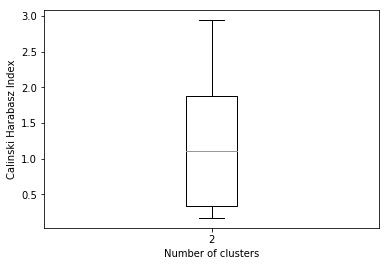

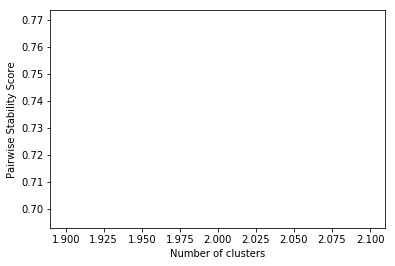

In [21]:
from gmvae_model import GMVAE
eval_epochs = 1
saver = tf.train.Saver(keep_checkpoint_every_n_hours=4)
CH_scores = []
stability_scores = []
clusters = range(2,3)
n_z = 2
n_x = dataset.train.data.shape[1]
for k in clusters:
    print("with k=",k,"clusters")
    model = GMVAE(k=k, n_x=n_x, n_z=n_z)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # TRAINING
        sess_info = (sess, saver)
        print("init")
        # For some reason we can't save when running on jupyter notebook, hence the last parameter
        # When we want to save our parameters, maybe just run a python script from a terminal instead?
        history = model.train('logs/gmvae_k={:d}.log'.format(k), dataset, sess_info, epochs=eval_epochs, save_parameters = False)

        multiplier = 10 # How many z:s we sample from one data point
        CH = sample_and_compute_calinski_harabaz(sess,
                               dataset.test.data,
                               model,
                               multiplier,
                               k,
                               n_z)
        CH_scores.append(CH)
        stability_score = compute_pairwise_stability(sess, model, dataset.test.data, k, n_z)
        stability_scores.append(stability_score)
a = box_plot(CH_scores, clusters)
b = plot(stability_scores, clusters)

In [22]:
#box_plot(CH_scores, clusters)

In [23]:
 #plot(stability_scores, clusters)

In [27]:
def get_corcoeffs(X, k, sess, model):
    names = list(X.columns)
    n_examples = 200
    old_pats = X[:n_examples]
    zvals = encode(old_pats, sess, model)
    # get some known patients.
    min_z = -3
    max_z = 3
    skip = 1

    distrs = []
    distrs_spectra = []
    for y in range(k):
        latent_vars = {}
        latent_var_spectra = {}
        for i in range(n_z):  # For each latent variable...
            latent_name = "z" + str(i)
            latent_vars[latent_name] = {}
            latent_var_spectra[latent_name] = np.zeros(len(names))
            layer = latent_vars[latent_name]
            for z in range(min_z, max_z, skip):  # ...fix the value of the latent variable (for a suite of values)
                zvals[:, i] = z
                new_pats = generate(y, zvals, sess, model)
                new_z = np.ones(n_examples) * z
                if "x" in layer:
                    layer["x"] = np.concatenate((layer["x"], new_pats), axis=0)
                else:
                    layer["x"] = new_pats
                if "z" in layer:
                    layer["z"] = np.concatenate((layer["z"], new_z), axis=0)
                else:
                    layer["z"] = new_z
            # Take the correlation between the latent variable and all other original data variables,
            # we'll call this the latent variable's "fingerprint" or "spectrum" and we want to compare the different latent vars
            for j, real_varname in enumerate(names):
                #print(latent_vars[latent_name]['x'])
                #print (np.corrcoef(latent_vars[latent_name]['z'], latent_vars[latent_name]['x']))
                latent_var_spectra[latent_name][j] = np.corrcoef(latent_vars[latent_name]['z'],\
                                                                 latent_vars[latent_name]['x'][:, j])[0, 1]
        distrs.append(latent_vars)
        distrs_spectra.append(latent_var_spectra)
    return distrs, distrs_spectra

## Plot GMVAE latent outputs, Relate inferred latent variables z & clusters y back to inputs x

In [28]:
from gmvae_model import GMVAE
from utils import *
plot = True
k = 2
n_x = X.shape[1]
n_z = 5
n_epochs=50
model = GMVAE(k=k, n_x=n_x, n_z=n_z)
saver = tf.train.Saver(keep_checkpoint_every_n_hours=4)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # TRAINING
    sess_info = (sess, saver)
    print("init")
    # For some reason we can't save when running on jupyter notebook, hence the last parameter
    # When we want to save our parameters, maybe just run a python script from a terminal instead?
    history = model.train('logs/gmvae_k={:d}.log'.format(k), dataset, sess_info, epochs=n_epochs, save_parameters = False)
    print("model trained")
    distrs, distrs_spectra = get_corcoeffs(X, k, sess, model)
    if (plot):
        plot_z(sess, X.as_matrix(), Y.as_matrix(), model, k, n_z)
        plot_gmvae_output(sess, X.as_matrix(), Y.as_matrix(), model, k)
    n = 3


graph written
init
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
 -6.51e-01,  2.72e+00,  6.45e-01,  2.85e+00,  1.00e+00
model trained


In [29]:
names = list(X.columns)
for y, latent_var_spectra in enumerate(distrs_spectra):
    print ("distribution ",y)
    for i in range(n_z):
        latent_name = "z" + str(i)
        print('\nTop {} associated variables for Latent Variable {}:'.format(n, latent_name))
        top_n_associated_indxs = np.argsort(np.abs(latent_var_spectra[latent_name]))[::-1][:n]
        for association in zip(np.array(names)[top_n_associated_indxs], 
                               latent_var_spectra[latent_name][top_n_associated_indxs]):
            print(association)

distribution  0

Top 3 associated variables for Latent Variable z0:
('meanPTT', -0.6365174152932204)
('meanPotassium', -0.6346713683376343)
('meanSodium', -0.6295608754672155)

Top 3 associated variables for Latent Variable z1:
('meanGlucose', 0.7026325353050874)
('meanPTT', -0.6997845564049087)
('meanPotassium', -0.6973139591624026)

Top 3 associated variables for Latent Variable z2:
('meanHematocrit', 0.9561334018422594)
('meanINR', -0.9557758496722378)
('meanChloride', 0.9550139907042491)

Top 3 associated variables for Latent Variable z3:
('meanGlucose', -0.9748765435426009)
('meanHematocrit', -0.876325371966747)
('meanPTT', 0.8749838603312533)

Top 3 associated variables for Latent Variable z4:
('meanHematocrit', -0.9985760818434186)
('meanINR', 0.9981914915763805)
('meanChloride', -0.9974612371740327)
distribution  1

Top 3 associated variables for Latent Variable z0:
('meanHematocrit', 0.9976701202576136)
('meanINR', -0.9962945600807837)
('meanGlucose', 0.9932698551169178)

Top 

## Plot spectra for each y

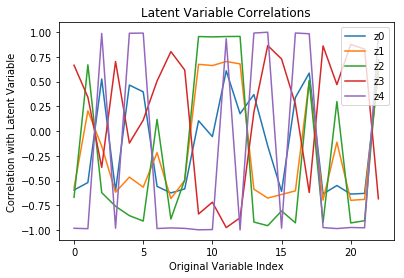

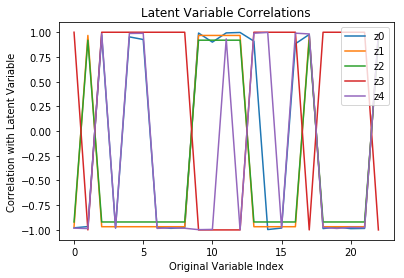

In [30]:
for y, latent_var_spectra in enumerate(distrs_spectra):
    for i in range(n_z):  # For each latent variable...
        plt.plot(latent_var_spectra["z" + str(i)], label="z" + str(i))
    plt.xlabel('Original Variable Index')
    plt.ylabel('Correlation with Latent Variable')
    plt.title('Latent Variable Correlations')
    plt.legend(loc='upper right')
    plt.show()